Importing all the important libraries

In [82]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [83]:
## Connect to Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [84]:
#!unzip gdrive/MyDrive/CNN_assignment

In [85]:
## Defining the path for train and test images

data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [86]:
##Check the size
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [87]:
#Define some parameters for the loader:
batch_size = 32
img_height = 180
img_width = 180

In [88]:
#Use 80% of the images for training, and 20% for validation.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [89]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [90]:
#Check for Class Names:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


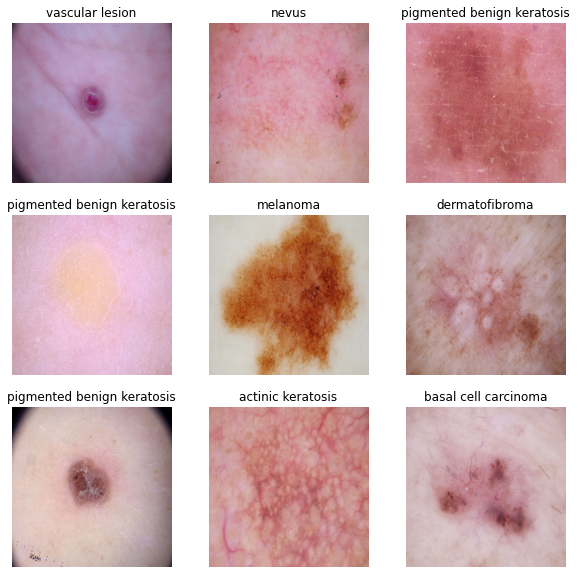

In [91]:
# View Samples
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [92]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

CREATE MODEL

In [93]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size. 
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size. 
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size. 
  layers.MaxPooling2D(),
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.Flatten(),
  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  layers.Dense(128, activation='relu'),
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])


In [94]:
#choose Adam as optimiser and CrossEntropy loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [95]:
# View the summary of all layers
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 45, 45, 64)       

TRAIN THE MODEL

In [96]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 21s 113ms/step - loss: 1.9685 - accuracy: 0.2751 - val_loss: 1.7590 - val_accuracy: 0.3803
Epoch 2/30
56/56 [==============================] - 3s 46ms/step - loss: 1.6123 - accuracy: 0.4314 - val_loss: 1.4934 - val_accuracy: 0.4899
Epoch 3/30
56/56 [==============================] - 3s 46ms/step - loss: 1.4456 - accuracy: 0.4838 - val_loss: 1.5106 - val_accuracy: 0.4832
Epoch 4/30
56/56 [==============================] - 3s 46ms/step - loss: 1.3816 - accuracy: 0.5167 - val_loss: 1.3908 - val_accuracy: 0.5347
Epoch 5/30
56/56 [==============================] - 3s 47ms/step - loss: 1.2995 - accuracy: 0.5469 - val_loss: 1.4172 - val_accuracy: 0.5168
Epoch 6/30
56/56 [==============================] - 3s 46ms/step - loss: 1.2370 - accuracy: 0.5742 - val_loss: 1.3645 - val_accuracy: 0.5526
Epoch 7/30
56/56 [==============================] - 3s 46ms/step - loss: 1.1103 - accuracy: 0.6021 - val_loss: 1.3069 - val_accuracy: 0.5570
Epoch 8/30


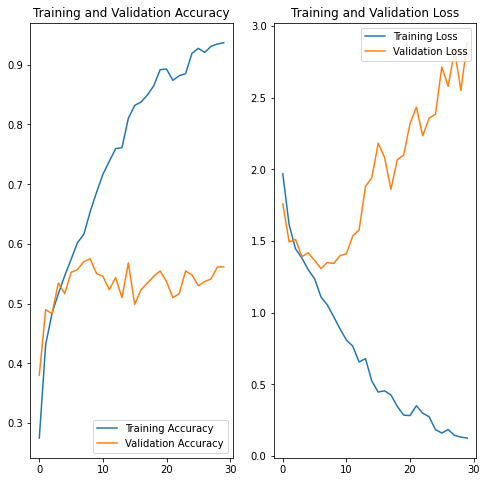

In [97]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [98]:
### Trying with larger filters
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.Flatten(),
  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  layers.Dense(128, activation='relu'),
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])

In [99]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# View the summary of all layers
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 45, 45, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 45, 45, 64)       

In [100]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 8s 135ms/step - loss: 2.0761 - accuracy: 0.2232 - val_loss: 2.0103 - val_accuracy: 0.2148
Epoch 2/30
56/56 [==============================] - 7s 132ms/step - loss: 1.7743 - accuracy: 0.3588 - val_loss: 1.5461 - val_accuracy: 0.4743
Epoch 3/30
56/56 [==============================] - 7s 131ms/step - loss: 1.4853 - accuracy: 0.4944 - val_loss: 1.4132 - val_accuracy: 0.5123
Epoch 4/30
56/56 [==============================] - 7s 131ms/step - loss: 1.4180 - accuracy: 0.5117 - val_loss: 1.4709 - val_accuracy: 0.5056
Epoch 5/30
56/56 [==============================] - 7s 131ms/step - loss: 1.3088 - accuracy: 0.5491 - val_loss: 1.4676 - val_accuracy: 0.4832
Epoch 6/30
56/56 [==============================] - 7s 131ms/step - loss: 1.2225 - accuracy: 0.5642 - val_loss: 1.3709 - val_accuracy: 0.5257
Epoch 7/30
56/56 [==============================] - 7s 132ms/step - loss: 1.1902 - accuracy: 0.5664 - val_loss: 1.4800 - val_accuracy: 0.5324
Epoch 

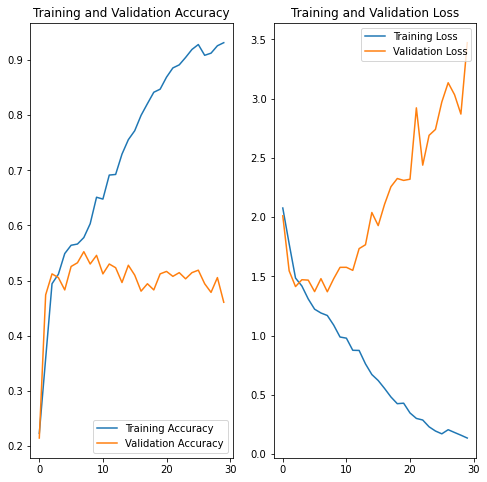

In [101]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

There is a gross overfitting as the model trains for more epochs. the gap ### between the training and validation acurracy seems to be still large

In [102]:
### Augmentation for a sample image

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode='constant'),
  ]
)

In [103]:
images[0]

<tf.Tensor: shape=(180, 180, 3), dtype=float32, numpy=
array([[[ 53.041668 ,  34.375    ,  53.541668 ],
        [ 66.25     ,  43.25     ,  64.375    ],
        [ 75.916664 ,  53.041664 ,  74.625    ],
        ...,
        [102.791595 ,  74.5      ,  97.37503  ],
        [101.       ,  67.5      ,  91.625    ],
        [ 89.41672  ,  61.291702 ,  84.16669  ]],

       [[ 55.625    ,  37.666664 ,  58.541664 ],
        [ 70.25     ,  45.375    ,  66.625    ],
        [ 81.541664 ,  56.166664 ,  77.45833  ],
        ...,
        [106.58331  ,  77.       , 100.79166  ],
        [102.625    ,  71.375    ,  93.75     ],
        [ 92.41672  ,  63.125015 ,  86.70839  ]],

       [[ 63.833332 ,  38.75     ,  60.       ],
        [ 74.       ,  48.375    ,  69.125    ],
        [ 82.       ,  56.791664 ,  78.166664 ],
        ...,
        [110.00006  ,  80.208405 , 103.79172  ],
        [105.       ,  73.75     ,  97.5      ],
        [ 94.50015  ,  65.25006  ,  90.79176  ]],

       ...,

     

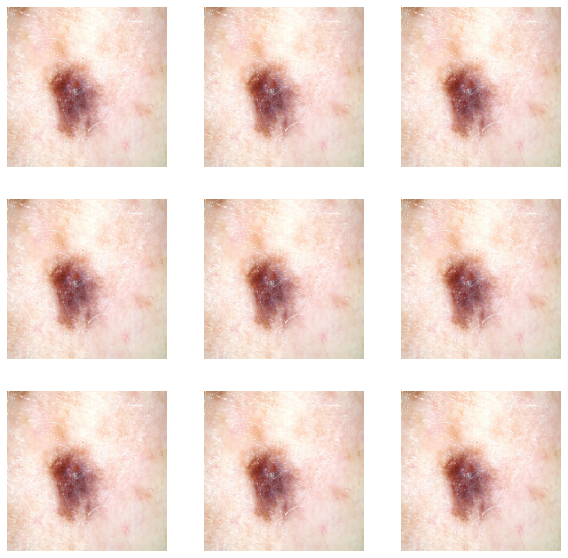

In [104]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [105]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
num_classes=9
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [106]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [107]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 56ms/step - loss: 1.9253 - accuracy: 0.2930 - val_loss: 1.7504 - val_accuracy: 0.3803
Epoch 2/20
56/56 [==============================] - 3s 54ms/step - loss: 1.6377 - accuracy: 0.4129 - val_loss: 1.5934 - val_accuracy: 0.4139
Epoch 3/20
56/56 [==============================] - 3s 53ms/step - loss: 1.5253 - accuracy: 0.4671 - val_loss: 1.4968 - val_accuracy: 0.4743
Epoch 4/20
56/56 [==============================] - 3s 53ms/step - loss: 1.4616 - accuracy: 0.4855 - val_loss: 1.4450 - val_accuracy: 0.5168
Epoch 5/20
56/56 [==============================] - 3s 52ms/step - loss: 1.4063 - accuracy: 0.5145 - val_loss: 1.3765 - val_accuracy: 0.5324
Epoch 6/20
56/56 [==============================] - 3s 54ms/step - loss: 1.3251 - accuracy: 0.5340 - val_loss: 1.3691 - val_accuracy: 0.5503
Epoch 7/20
56/56 [==============================] - 3s 54ms/step - loss: 1.3239 - accuracy: 0.5324 - val_loss: 1.3680 - val_accuracy: 0.5235
Epoch 8/20
56

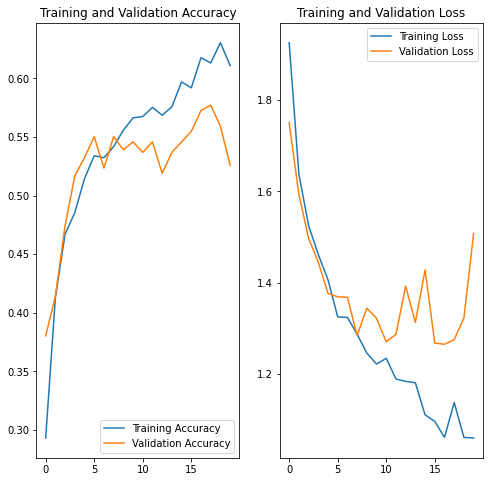

In [108]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

While the overfitting issue has been arrested, the accuracy still needs to be watched.

In [109]:
### Finding Class imbalance

In [110]:
## Class imbalance
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print (len(path_list))
print (len(lesion_list))

2239
2239


In [111]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
1,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
2,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
3,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
4,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Skin cancer ISIC The I...,squamous cell carcinoma
2235,/content/gdrive/MyDrive/Skin cancer ISIC The I...,squamous cell carcinoma
2236,/content/gdrive/MyDrive/Skin cancer ISIC The I...,squamous cell carcinoma
2237,/content/gdrive/MyDrive/Skin cancer ISIC The I...,squamous cell carcinoma


<BarContainer object of 9 artists>

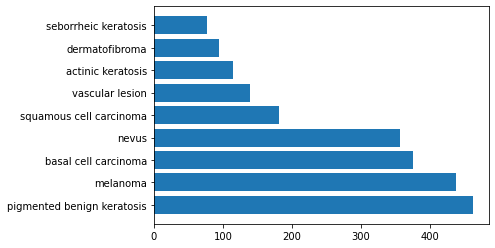

In [112]:
graph=original_df.Label.value_counts()

graph_df=graph.to_frame()

plt.barh(graph_df.index,graph_df.Label)

In [113]:
# seborrheic keratosis has the least number of samples
# pigmented benign keratosis and melanoma dominate the lot with the highest number of samples

In [114]:
!pip install Augmentor

In [119]:
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=722x545 at 0x7F528765DCD0>: 100%|██████████| 500/500 [00:48<00:00, 10.31 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F53701F3D90>: 100%|██████████| 500/500 [00:57<00:00,  8.75 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F52FC666290>: 100%|██████████| 500/500 [00:55<00:00,  9.07 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F52FC75E6D0>: 100%|██████████| 500/500 [00:47<00:00, 10.59 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F52FF7CC6D0>: 100%|██████████| 500/500 [00:51<00:00,  9.77 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F52FD5B33D0>: 100%|██████████| 500/500 [00:50<00:00,  9.96 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=2816x2112 at 0x7F53701B3390>: 100%|██████████| 500/500 [00:58<00:00,  8.51 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F52FF7F5E50>: 100%|██████████| 500/500 [00:56<00:00,  8.86 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5378761210>: 100%|██████████| 500/500 [00:52<00:00,  9.57 Samples/s]


In [120]:
!ls /content/gdrive/MyDrive/Skin\ cancer\ ISIC\ The\ International\ Skin\ Imaging\ Collaboration/Train/output

'actinic keratosis'	 melanoma		      'seborrheic keratosis'
'basal cell carcinoma'	 nevus			      'squamous cell carcinoma'
 dermatofibroma		'pigmented benign keratosis'  'vascular lesion'


In [121]:
mv '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output'  '/content/gdrive/MyDrive/Final'

In [122]:
cp /content/gdrive/MyDrive/Skin\ cancer\ ISIC\ The\ International\ Skin\ Imaging\ Collaboration/Train/dermatofibroma/*.jpg /content/gdrive/MyDrive/Final/dermatofibroma

In [123]:
cp /content/gdrive/MyDrive/Skin\ cancer\ ISIC\ The\ International\ Skin\ Imaging\ Collaboration/Train/actinic\ keratosis/*.jpg /content/gdrive/MyDrive/Final/actinic\ keratosis

In [124]:
cp /content/gdrive/MyDrive/Skin\ cancer\ ISIC\ The\ International\ Skin\ Imaging\ Collaboration/Train/basal\ cell\ carcinoma/*.jpg /content/gdrive/MyDrive/Final/basal\ cell\ carcinoma

In [125]:
cp /content/gdrive/MyDrive/Skin\ cancer\ ISIC\ The\ International\ Skin\ Imaging\ Collaboration/Train/melanoma/*.jpg /content/gdrive/MyDrive/Final/melanoma

In [126]:
cp /content/gdrive/MyDrive/Skin\ cancer\ ISIC\ The\ International\ Skin\ Imaging\ Collaboration/Train/nevus/*.jpg /content/gdrive/MyDrive/Final/nevus

In [127]:
cp /content/gdrive/MyDrive/Skin\ cancer\ ISIC\ The\ International\ Skin\ Imaging\ Collaboration/Train/pigmented\ benign\ keratosis/*.jpg /content/gdrive/MyDrive/Final/pigmented\ benign\ keratosis

In [128]:
cp /content/gdrive/MyDrive/Skin\ cancer\ ISIC\ The\ International\ Skin\ Imaging\ Collaboration/Train/seborrheic\ keratosis/*.jpg /content/gdrive/MyDrive/Final/seborrheic\ keratosis

In [129]:
cp /content/gdrive/MyDrive/Skin\ cancer\ ISIC\ The\ International\ Skin\ Imaging\ Collaboration/Train/squamous\ cell\ carcinoma/*.jpg /content/gdrive/MyDrive/Final/squamous\ cell\ carcinoma

In [130]:
cp /content/gdrive/MyDrive/Skin\ cancer\ ISIC\ The\ International\ Skin\ Imaging\ Collaboration/Train/vascular\ lesion/*.jpg /content/gdrive/MyDrive/Final/vascular\ lesion

In [131]:
data_dir_final='/content/gdrive/MyDrive/Final'
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_final, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

6739

In [132]:
batch_size = 32
img_height = 180
img_width = 180

In [133]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_final,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [134]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_final,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [135]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [136]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(9)
])

In [137]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [138]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 49s 95ms/step - loss: 1.8722 - accuracy: 0.3168 - val_loss: 1.6281 - val_accuracy: 0.4417
Epoch 2/30
169/169 [==============================] - 8s 47ms/step - loss: 1.4439 - accuracy: 0.4950 - val_loss: 1.3992 - val_accuracy: 0.4922
Epoch 3/30
169/169 [==============================] - 8s 46ms/step - loss: 1.2332 - accuracy: 0.5593 - val_loss: 1.1543 - val_accuracy: 0.5880
Epoch 4/30
169/169 [==============================] - 8s 47ms/step - loss: 1.0463 - accuracy: 0.6307 - val_loss: 1.0476 - val_accuracy: 0.6095
Epoch 5/30
169/169 [==============================] - 8s 46ms/step - loss: 0.8923 - accuracy: 0.6821 - val_loss: 1.0750 - val_accuracy: 0.6117
Epoch 6/30
169/169 [==============================] - 8s 46ms/step - loss: 0.7537 - accuracy: 0.7315 - val_loss: 0.9921 - val_accuracy: 0.6540
Epoch 7/30
169/169 [==============================] - 8s 46ms/step - loss: 0.6080 - accuracy: 0.7845 - val_loss: 0.8583 - val_accuracy: 0.719

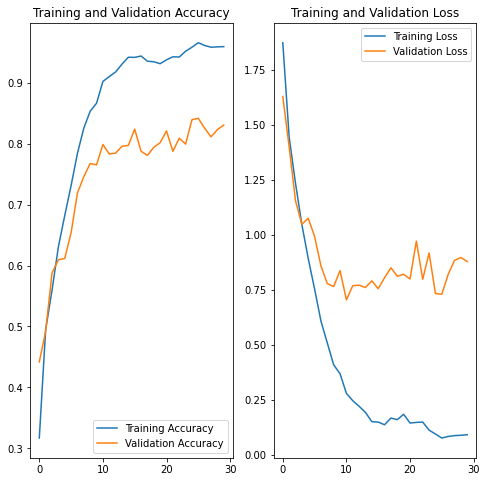

In [139]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Thus the Training,Test Accuracy has improved considerably using data augmentation